<a href="https://colab.research.google.com/github/lapshinaaa/recsys-tasks/blob/main/RecSys2_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Recommender Systems — Notebook #2</center></h1>

<center>
<img src="https://avatars.mds.yandex.net/get-grocery-goods/2783132/ab847ff6-95e3-4c4e-831a-0576d1949a9e/orig" width="300" />
</center>

**In this notebook, we will work through the following:**

- Explore the dataset of user interaction events from the **Yandex Lavka** application.
- Review the course competition (Kaggle contest):  
  https://www.kaggle.com/t/eb7d5a01648e4e7cb0dfa404d29497ea
- Implement a **baseline recommender model**.
- Train more advanced models (e.g., **CatBoost** for ranking).
- Implement several **new ranking quality metrics**.

In [1]:
!pip install catboost
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 75.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
import zipfile
import requests

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from textwrap import wrap
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score, log_loss, ndcg_score

# 🗄 Dataset:

In [3]:
def download_and_extract(url: str, filename: str, chunk_size: int = 1024):
    # load the file
    response = requests.get(url, stream=True)
    response.raise_for_status()

    total_size = int(response.headers.get('content-length', 0))

    # write the file
    with open(filename, "wb") as f:
        with tqdm(
            total=total_size,
            unit='B',
            unit_scale=True,
            desc=filename,
            bar_format='{l_bar}{bar:50}{r_bar}{bar:-50b}'  # формат для красоты
        ) as pbar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))

    # unzip archive
    with zipfile.ZipFile(filename, "r") as zip_ref:
        print(f"\nUnpacking {filename}...")
        zip_ref.extractall(".")
        print(f"Files from {filename} successfully extracted\n")

In [4]:
download_and_extract(
    url="https://www.kaggle.com/api/v1/datasets/download/thekabeton/ysda-recsys-2025-lavka-dataset",
    filename="lavka.zip"
)

lavka.zip:   0%|                                                  | 0.00/447M [00:00<?, ?B/s]


Unpacking lavka.zip...
Files from lavka.zip successfully extracted



In [5]:
train = pl.read_parquet('train.parquet')
test = pl.read_parquet('test.parquet')

# for kaggle: train = train.sample(200000, shuffle=True)

train.head(100)

action_type,city_name,position_in_request,product_category,product_id,product_image,product_name,request_id,source_type,store_id,timestamp,user_id
str,str,i64,str,u64,str,str,u64,str,u64,i64,u64
"""AT_View""","""Екатеринбург""",20,"""Колбаса сырокопченая/сыровялен…",15622873057108008619,"""https://avatars.mds.yandex.net…","""Колбаса сервелат-салями Элитна…",9541715973781753063,"""ST_Search""",14539184420433789706,1692527447,7421231689159170748
"""AT_View""","""Москва""",68,"""ПАСТА С МЯСОМ ПТИЦЫ""",17225686928570569253,"""https://avatars.mds.yandex.net…","""Паста с куриной грудкой в слив…",8471250031114211515,"""ST_Search""",14058715110002771508,1686479624,135364936461809128
"""AT_View""","""Москва""",8,"""Бумажные полотенца""",9571392871249924586,"""https://avatars.mds.yandex.net…","""Полотенца бумажные Zewa, 4 шт.""",16057244839195726423,"""ST_SearchStartRec""",9463368652572089691,1691202307,7846147652438475366
"""AT_Purchase""","""Нижний Новгород""",null,"""КОТЛЕТА МЯСНАЯ С ОВОЩАМИ""",2281275230546064866,"""https://avatars.mds.yandex.net…","""Котлета нежная с гречкой и ово…",null,null,4220451351681881198,1683883091,365744836962066469
"""AT_View""","""Москва""",37,"""Сок яблочный восстановленный о…",6458244614391609220,"""https://avatars.mds.yandex.net…","""Напиток сокосодержащий Яблоко …",11838631385573779102,"""ST_Search""",4666210310211554321,1691893320,13306396713639957054
…,…,…,…,…,…,…,…,…,…,…,…
"""AT_View""","""Санкт-Петербург""",10,"""Сухарики ржаные""",17686447349709024690,"""https://avatars.mds.yandex.net…","""Мягкие сухарики ржаные «Рускар…",2053082441286200046,"""ST_Feed""",11357481843120016483,1703317905,18261157470648967742
"""AT_View""","""Москва""",63,"""Мороженое в рожке""",5721552500721809715,"""https://avatars.mds.yandex.net…","""Мороженое молочное Twix в рожк…",6438297417984825472,"""ST_Upsale""",3203612745131519532,1700185898,11800795575902804369
"""AT_CartUpdate""","""Санкт-Петербург""",8,"""Сало соленое нарезка""",5302455702714587812,"""https://avatars.mds.yandex.net…","""Сало Белорусское «Из Лавки» со…",4931898230811196031,"""ST_Upsale""",5020869520581891290,1688986372,18236687034544145648


In [6]:
test.head(5)

index,city_name,product_category,product_id,product_image,product_name,request_id,source_type,store_id,user_id,timestamp
u32,str,str,u64,str,str,u64,str,u64,u64,i64
0,"""Москва""","""Зеленый лук""",1011877333410564487,"""https://avatars.mds.yandex.net…","""Зелёный лук, 100 г""",3163138746887074859,"""ST_SearchComplementRec""",6957231662172505082,16269684363668191286,1708064189
1,"""Москва""","""Напитки газированные фруктовые…",13643897241584695507,"""https://avatars.mds.yandex.net…","""Напиток «Добрый» вкус лимон-ла…",10695554269036072961,"""ST_Upsale""",1161849852314740349,4723061940815112962,1708248789
2,"""Москва""","""Творожные сыры с добавками""",662268006213558306,"""https://avatars.mds.yandex.net…","""Сыр творожный Almette с зелень…",4035275887687231237,"""ST_Search""",14842344342271362286,8190566140622338193,1707017903
3,"""Москва""","""Пудинги молочные""",6766471268187459277,"""https://avatars.mds.yandex.net…","""Пудинг ванильный Hyper High Pr…",17345676267072687181,"""ST_SearchComplementRec""",4170583338408144505,7071136374412213957,1707915068
4,"""Москва""","""Ветчина из мяса птицы нарезка""",12166964200067122997,"""https://avatars.mds.yandex.net…","""Ветчина из филе индейки Мрамор…",5992911504822469765,"""ST_Feed""",15417862495487613164,7022354297088103908,1708011493


# 👀 Taking a look at the dataset

In [7]:
train.group_by(
    "action_type"
).agg(
    pl.len().alias("total_actions")
)

action_type,total_actions
str,u32
"""AT_CartUpdate""",307954
"""AT_View""",15732595
"""AT_Purchase""",216596
"""AT_Click""",251469


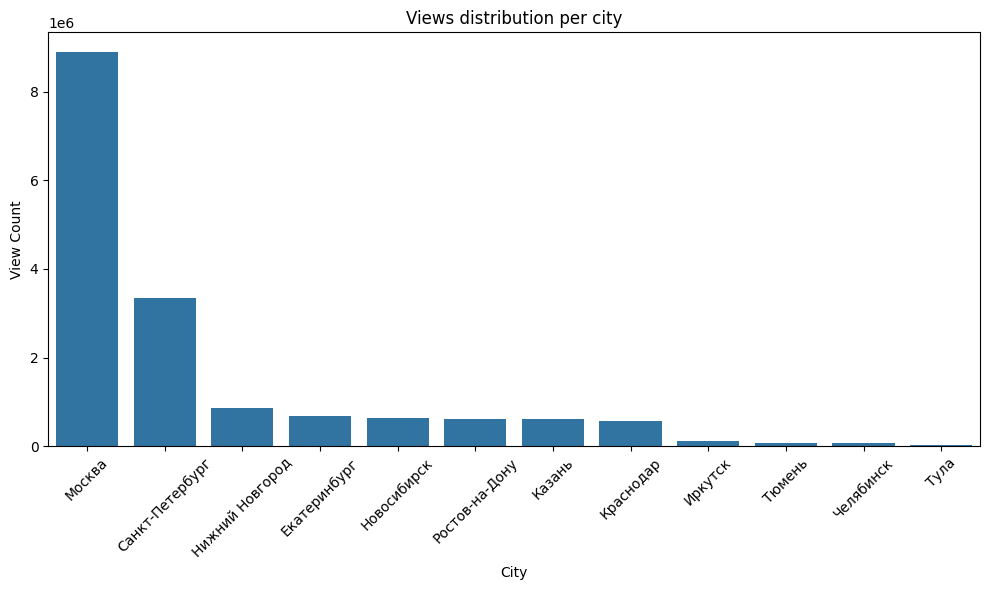

In [8]:
city_analysis = train.group_by("city_name").agg(
    pl.len().alias("actions_count")
).sort("actions_count", descending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="city_name",
    y="actions_count",
    data=city_analysis.to_pandas()
)
plt.title("Views distribution per city")
plt.xlabel("City")
plt.ylabel("View Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Taking a look at the most popular purchases:

In [9]:
top_10 = train.filter(
    pl.col('action_type') == 'AT_Purchase'  # keeping the rows where the purchase was actually made
).group_by(
    'product_name'
).agg(
    pl.len().alias("total_purchase"),
    pl.col('product_image').first()
).sort(
    'total_purchase', descending=True
).head(10)

top_10

product_name,total_purchase,product_image
str,u32,str
"""Майка-пакет с логотипом «Яндек…",10915,"""https://avatars.mds.yandex.net…"
"""Майка-пакет с логотипом Яндекс…",1786,"""https://avatars.mds.yandex.net…"
"""Джиббитса «Зверский детектив»,…",1051,"""https://avatars.mds.yandex.net…"
"""Спелый банан, 1 шт.""",573,"""https://avatars.mds.yandex.net…"
"""Энергетический напиток Adrenal…",548,"""https://avatars.mds.yandex.net…"
"""Молоко 2,5% «Простоквашино» па…",539,"""https://avatars.mds.yandex.net…"
"""Батон Нарезной «Черёмушки» в н…",523,"""https://avatars.mds.yandex.net…"
"""Зелёный банан, 1 шт.""",465,"""https://avatars.mds.yandex.net…"
"""Пирожное бисквитное Kinder Мол…",402,"""https://avatars.mds.yandex.net…"


In [10]:
def load_poster(row):
    title, poster_url = row[0], row[2]
    try:
        response = requests.get(poster_url, timeout=20)
        response.raise_for_status()
        return Image.open(BytesIO(response.content)), title

    except Exception as e:
        print(f"Error loading poster for '{title}': {e}")
        return None, None

def show_posters(data):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    rows = [row for row in data.iter_rows()]

    with ThreadPoolExecutor(max_workers=10) as executor:
        results = list(executor.map(load_poster, rows))

    for idx, (img, title) in enumerate(results):
        ax = axes[idx//5, idx%5]
        if img and title:
            ax.imshow(img)
            wrapped_title = "\n".join(wrap(title, width=40))
            ax.set_title(wrapped_title)
        else:
            ax.set_title("Image not available", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

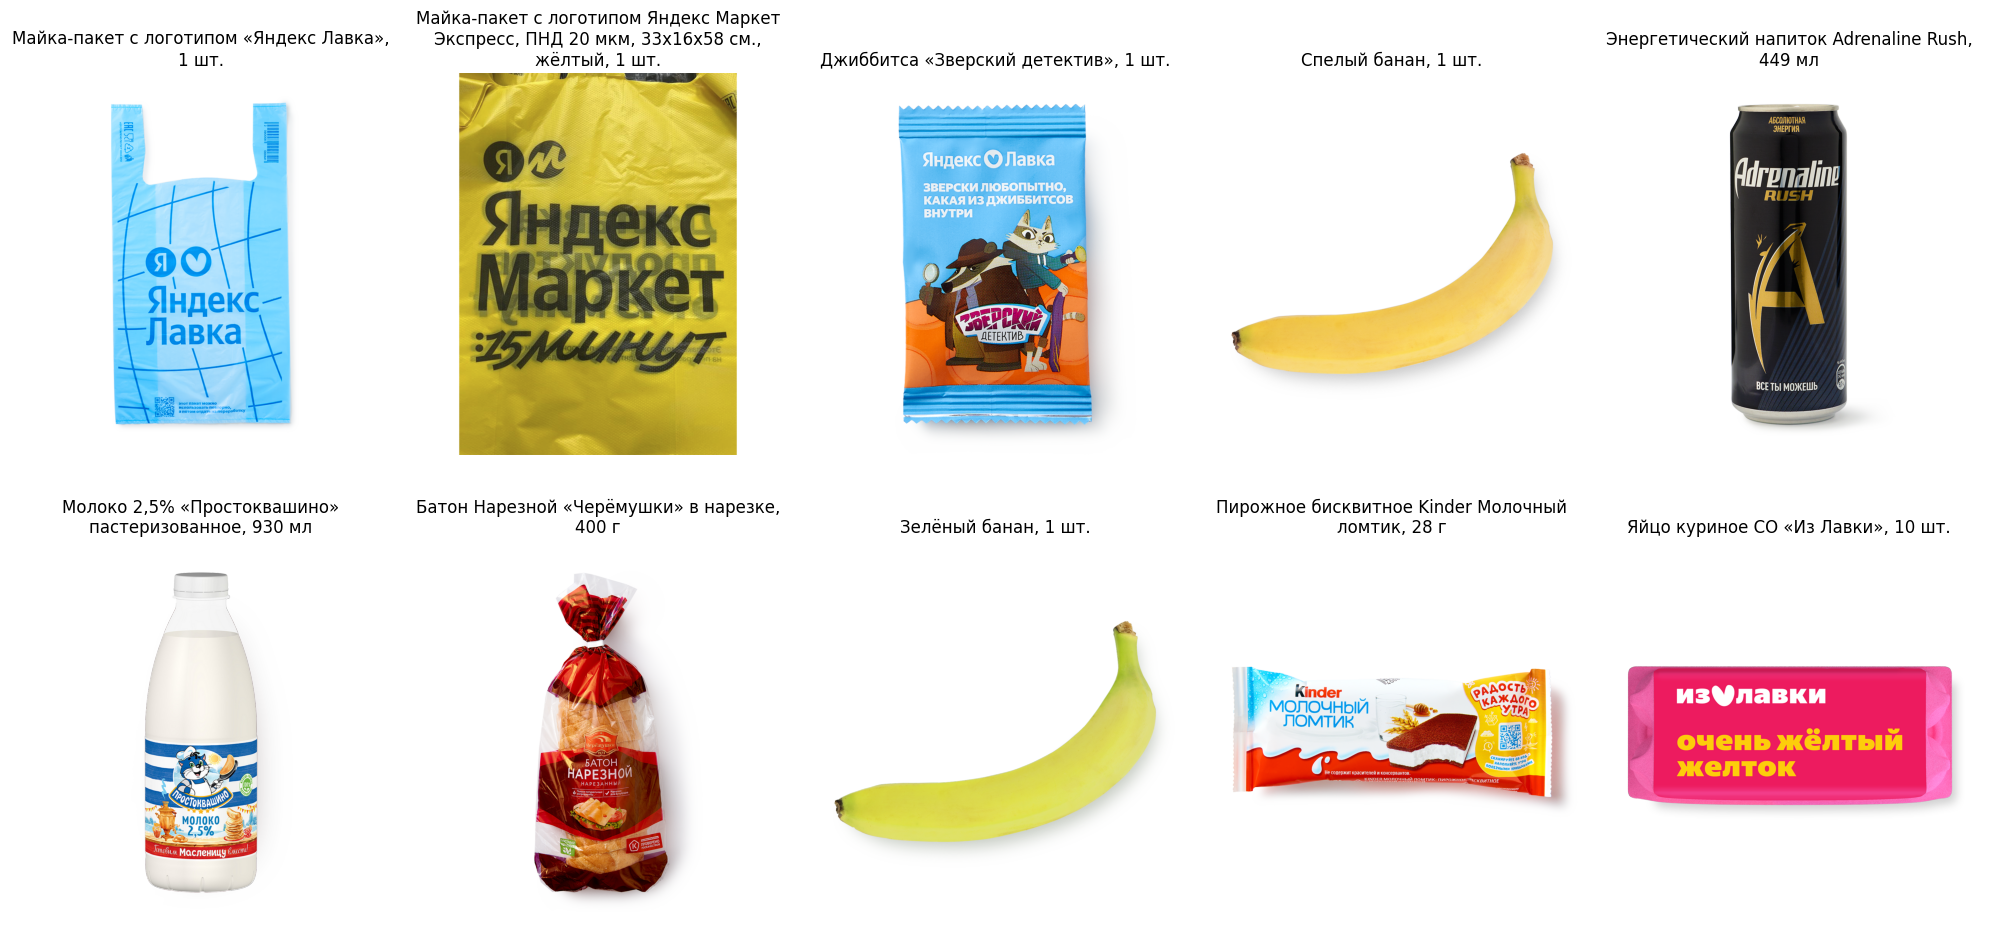

In [11]:
show_posters(top_10)

# 🎲 Random Submit:

In [12]:
random_submit = test.select(
    'index',
    'request_id'
).sample(
    fraction=1.0,
    shuffle=True
)

# random_submit.write_csv('random_submit.csv')

random_submit

index,request_id
u32,u64
262631,13480649503697516061
15492,15731208969901896487
171611,2412523596941209841
110386,14407223463503456466
82826,3719189251347889848
…,…
250866,8528827862168187435
115056,2183905949732247969
11616,15996554989203160293


# 📈 Baseline:

In [13]:
count_purchase_in_train = train.filter(
    pl.col('action_type') == "AT_Purchase"
).group_by(
    'user_id',
    'product_id'
).agg(
    pl.len()
)

count_purchase_in_train

user_id,product_id,len
u64,u64,u32
15711244575441609473,396826536229659829,1
4958948218135991834,7260956287449353235,4
3897174653621005405,16750146205376481862,1
12461090344745746192,12040362470436115017,1
7593160962697934912,247576409957363040,23
…,…,…
14846571999163903771,14879180124857338226,1
9498935477028340210,8115842986987705737,1
3394613414290654910,14806087884605785873,1


In [14]:
baseline_submit = test.join(
    count_purchase_in_train,
    on=["user_id", "product_id"],
    how="left"
).with_columns(
    pl.col("len").fill_null(0)
).sort(
    'len',
    descending=True
).select(
    'index',
    'request_id'
)

# baseline_submit.write_csv('baseline_submit.csv')

baseline_submit

index,request_id
u32,u64
3327,8326074374293585629
22843,17974084561053841512
31825,9963616371821641702
41085,15172976654890465818
45354,8229327635474235215
…,…
292819,1072314311971942569
292820,14277264955890121535
292821,18245759681975122324


# 🦾 CatBoost

Let's extract some features from the data and train a gradient boosting model.  
A key point here is to **avoid temporal leakage**.  
The model **must not see information from the future** when generating features.

To handle this correctly, we will split the labeled data into **three parts**:

- The **second** part will be used for **training**
- The **third** part will be used for **validation**
- The **first** part will be used to compute statistics **for the training set**
- For validation, statistics should be computed using both the **first + second** parts together

This ensures that **each sample’s features are calculated only from data available before that moment**, preserving a realistic training setup.

#### Splitting train into 3 parts:

In [15]:
train_len_div3 = int(len(train) / 3)

train = train.sort(
    'timestamp'
)

train_part1 = train[:train_len_div3]
train_part2 = train[train_len_div3:train_len_div3 * 2]
train_part3 = train[train_len_div3 * 2:]

Calculating the number of purchases of each item for each user on the first portion of train:

In [16]:
def calculate_count_purchase_by_user_and_product(dataset: pl.DataFrame) -> pl.DataFrame:
    count_purchase_by_user_and_product = dataset.filter(
        pl.col('action_type') == "AT_Purchase"
    ).group_by(
        'user_id',
        'product_id'
    ).agg(
        pl.len().alias('count_purchase_by_user_and_product')
    )

    return count_purchase_by_user_and_product

count_purchase_by_user_and_product_for_train = calculate_count_purchase_by_user_and_product(train_part1)

assert set(count_purchase_by_user_and_product_for_train.columns) == set(['user_id', 'product_id', 'count_purchase_by_user_and_product'])

count_purchase_by_user_and_product_for_train.head(5)

user_id,product_id,count_purchase_by_user_and_product
u64,u64,u32
6266068892494584888,5634551529266454974,1
17714739449633299784,4815686982446098365,1
6793907255420102248,10877062856578925306,1
4723061940815112962,11586455112286391814,1
5016533757132531420,3937565588543787391,1


Not let us calculate CTR of products for each user.

CTR (Click-Through Rate) — Click to View Ratio.

In our case - ratio of AT_Click to AT_View.

Let us calculate CTR for each item for the first portion of train:

In [17]:
def calculate_ctr(dataset: pl.DataFrame) -> pl.DataFrame:
    data = train_part1.group_by(
        'action_type',
        'product_id'
    ).agg(
        pl.len()
    )

    clicks = data.filter(
         pl.col('action_type') == "AT_Click"
    )

    views = data.filter(
         pl.col('action_type') == "AT_View"
    )

    ctr = clicks.join(
        views,
        on='product_id'
    ).with_columns(
        ctr=pl.col('len') / pl.col('len_right')
    ).select(
        'product_id',
        'ctr'
    )

    return ctr

ctr_for_train = calculate_ctr(train_part1)

assert set(ctr_for_train.columns) == set(['product_id', 'ctr'])

ctr_for_train.head(5)

product_id,ctr
u64,f64
2610077919254787006,0.043922
17233374065589726424,0.009901
2200440783118486063,0.019231
1624804940209713834,0.032694
2084351535901091046,0.037736


Creating training pool for CatBoost. Taking events from the second portion of the data and "glueing" created features to them:

In [18]:
def join_features_to_dataset(
    dataset: pl.DataFrame,
    count_purchase_by_user_and_product: pl.DataFrame,
    ctr: pl.DataFrame
) -> pl.DataFrame:
    catboost_pool = dataset.filter(
        pl.col('action_type').is_in(["AT_View", "AT_CartUpdate"])
    ).with_columns(
        target=pl.when(pl.col('action_type') == "AT_View").then(0).otherwise(1)
    ).group_by(
        ['product_id', 'request_id']
    ).max().drop(
        'source_type',
        'store_id',
        'timestamp',
        'product_image',
        'product_name',
        'city_name',
        'position_in_request',
        'product_category',
        'action_type'
    ).join(
        ctr,
        on='product_id',
        how='left'
    ).join(
        count_purchase_by_user_and_product,
        on=['user_id', 'product_id'],
        how='left'
    )

    return catboost_pool

train_catboost = join_features_to_dataset(
    train_part2,
    calculate_count_purchase_by_user_and_product(train_part1),
    calculate_ctr(train_part1)
)

assert set(train_catboost.columns) == set(['ctr', 'count_purchase_by_user_and_product', 'target', 'request_id', 'product_id', 'user_id'])

train_catboost.head(5)

product_id,request_id,user_id,target,ctr,count_purchase_by_user_and_product
u64,u64,u64,i32,f64,u32
12902938321559032064,18336427123144496365,796693056229886951,0,0.064327,null
15292179301566831444,9928585389623505202,14866405844321519780,0,0.023726,null
1625303204762302691,15410745823343173508,4043390425918995692,0,0.019255,null
14318504789130327253,6213643757808323683,1604601038323926601,0,null,null
5051276436210146347,13509787182803418198,2029102149129961995,0,0.013277,null


Same thing for the validation portion. Calc features using the 1 and 2 portions, then adding it to the third (val) part:

In [19]:
train_parts_1_2 = pl.concat([train_part1, train_part2])

val_catboost = join_features_to_dataset(
    train_part3,
    calculate_count_purchase_by_user_and_product(train_parts_1_2),
    calculate_ctr(train_parts_1_2)
)

val_catboost.head(5)

product_id,request_id,user_id,target,ctr,count_purchase_by_user_and_product
u64,u64,u64,i32,f64,u32
12611524194226212460,5037336775792285740,17614679643575552544,0,null,null
2959690642800193116,11350804277675858670,9510438755097650182,0,null,null
2693579592661014159,3127549414410234563,4723061940815112962,0,0.025,null
14943487878212155920,12909149653373159215,5016533757132531420,0,0.020742,null
13927125427616075980,11688932544670569237,15703791007365721369,0,0.013158,null


#### Training CatBoost:

In [20]:
from catboost import CatBoostClassifier, Pool

# data example
train_data = Pool(
    data=train_catboost.drop(['target', 'request_id', 'product_id', 'user_id']).to_pandas(),
    label=train_catboost['target'].to_list()
)

val_data = Pool(
    data=val_catboost.drop(['target', 'request_id', 'product_id', 'user_id']).to_pandas(),
    label=val_catboost['target'].to_list()
)

In [21]:
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.01,
    depth=2,
    loss_function="Logloss",
    eval_metric="AUC",
    early_stopping_rounds=50,
)

In [22]:
model.fit(
    train_data,
    eval_set=val_data,
    # plot=True
)

0:	test: 0.5934533	best: 0.5934533 (0)	total: 1.66s	remaining: 8m 16s
1:	test: 0.5945003	best: 0.5945003 (1)	total: 2.65s	remaining: 6m 35s
2:	test: 0.5945095	best: 0.5945095 (2)	total: 3.65s	remaining: 6m 1s
3:	test: 0.5943337	best: 0.5945095 (2)	total: 4.7s	remaining: 5m 47s
4:	test: 0.5943161	best: 0.5945095 (2)	total: 5.73s	remaining: 5m 38s
5:	test: 0.5946686	best: 0.5946686 (5)	total: 6.77s	remaining: 5m 31s
6:	test: 0.5950331	best: 0.5950331 (6)	total: 7.98s	remaining: 5m 33s
7:	test: 0.5949692	best: 0.5950331 (6)	total: 9.12s	remaining: 5m 32s
8:	test: 0.5948907	best: 0.5950331 (6)	total: 10.2s	remaining: 5m 29s
9:	test: 0.5949056	best: 0.5950331 (6)	total: 11.3s	remaining: 5m 26s
10:	test: 0.6177351	best: 0.6177351 (10)	total: 12.9s	remaining: 5m 40s
11:	test: 0.6177353	best: 0.6177353 (11)	total: 14.6s	remaining: 5m 50s
12:	test: 0.6177643	best: 0.6177643 (12)	total: 15.7s	remaining: 5m 46s
13:	test: 0.6185968	best: 0.6185968 (13)	total: 16.8s	remaining: 5m 43s
14:	test: 0.61

In [23]:
y_pred_proba = model.predict_proba(val_catboost.drop(['target']).to_pandas())[:, 1]

roc_auc = roc_auc_score(val_catboost['target'].to_list(), y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

logloss = log_loss(val_catboost['target'].to_list(), y_pred_proba)
print(f"LogLoss: {logloss:.4f}")

ROC AUC: 0.6186
LogLoss: 0.4608


#### Feature Importance:

In [24]:
for name, fstr in zip(model.feature_names_, model.feature_importances_):
    print(name, ':', fstr)

ctr : 7.803898717662561
count_purchase_by_user_and_product : 92.19610128233744


The model assigned the highest importance to the feature
`count_purchase_by_user_and_product`, which is expected because it represents a direct,
personal behavioral signal. If a user previously purchased an item multiple times,
this is the strongest indicator of future preference.

The CTR feature, while still useful, captures only a global measure of product appeal
and does not take individual user taste into account. Therefore, it serves as a
fallback signal when personal history is weak or unavailable.

Remaking the JOIN function for test portion:

In [25]:
def join_features_to_val_dataset(
    dataset: pl.DataFrame,
    count_purchase_by_user_and_product: pl.DataFrame,
    ctr: pl.DataFrame
) -> pl.DataFrame:
    catboost_pool = dataset.drop(
        'source_type',
        'store_id',
        'timestamp',
        'city_name',
        'product_name',
        'product_category',
        'product_image'
    ).join(
        ctr,
        on='product_id',
        how='left'
    ).join(
        count_purchase_by_user_and_product,
        on=['user_id', 'product_id'],
        how='left'
    )

    catboost_pool = catboost_pool.drop(
        'user_id',
        'product_id',
        'request_id'
    )

    return catboost_pool

In [26]:
kaggle_catboost = join_features_to_val_dataset(
    test,
    calculate_count_purchase_by_user_and_product(train),
    calculate_ctr(train)
)

kaggle_catboost.head(5)

index,ctr,count_purchase_by_user_and_product
u32,f64,u32
0,0.001947,null
1,0.008739,10
2,0.006593,17
3,0.023339,1
4,null,null


In [27]:
test_data = test['index', 'request_id']

test_data.with_columns(
    predict=model.predict_proba(kaggle_catboost.to_pandas())[:, 1]
).sort(
    'predict',
    descending=True
).select(
    'index',
    'request_id'
).write_csv('cb_submit.csv')

In [28]:
val_catboost

product_id,request_id,user_id,target,ctr,count_purchase_by_user_and_product
u64,u64,u64,i32,f64,u32
12611524194226212460,5037336775792285740,17614679643575552544,0,null,null
2959690642800193116,11350804277675858670,9510438755097650182,0,null,null
2693579592661014159,3127549414410234563,4723061940815112962,0,0.025,null
14943487878212155920,12909149653373159215,5016533757132531420,0,0.020742,null
13927125427616075980,11688932544670569237,15703791007365721369,0,0.013158,null
…,…,…,…,…,…
8817037096041388006,3739261542236665361,2349591888071211039,0,0.002809,null
3491226916937833582,4558397229968565693,10502931869573659853,0,0.020408,null
9387204425759437,1808363685497167319,8372683036902000730,0,0.008186,null


# 🎯 Ranking Quality Metrics

Basically, the following code prepares per-session lists of ground truth labels and predicted scores (padded to length 10 since we're doing @10 for all metrics) so we can correctly compute ranking quality metrics.

In [29]:
import sklearn

catboost_predicts = val_catboost.with_columns(
    predict=model.predict_proba(val_catboost.drop(['target']).to_pandas())[:, 1]
)

true = []
pred = []

for i in catboost_predicts.group_by('request_id'):
    value = i[1].sort('target', descending=True)[:10] # we're sorting items in the request by TRUE relevance
    if sum(value['target']) == 0: # skip sessions where no items were clicked
        continue
    l = [0] * (10 - len(value['target']))
    true.append(value['target'].to_list() + l)
    pred.append(value['predict'].to_list() + l)

# Formulas for MAP@K (Mean Average Precision at K)

## 1. **Precision@K**
Portion of relevant documents among `K` first results:
$$
\text{Precision}@K = \frac{\text{Number of relevant documents in top-}K}{K}
$$

---

## 2. **Average Precision@K (AP@K)**
Average precision of one request, considering positions of relevant docs in top-`K`:
$$
\text{AP}@K = \frac{\sum_{k=1}^{K} \text{Precision}@k \cdot \text{rel}(k)}{\text{Number of Relevant Documents in Top-}K}
$$
- `rel(k)` = 1, if the doc at `k` is relevant, otherwise 0.
- If in top-`K` there are no relevant docs, then `AP@K = 0`.

---

## 3. **MAP@K (Mean Average Precision at K)**
Average AP@K for all requests:
$$
\text{MAP}@K = \frac{1}{Q} \sum_{q=1}^{Q} \text{AP}@K^{(q)}
$$
- `Q` — overall number of requests (quieries).
-  $AP@K^{(q)}$ — Average Precision@K for quiery (request) `q`.

In [30]:
def ap_at_k(y_true, y_pred, k):
    if np.sum(y_true) == 0:
        return 0.0
    sorted_indices = np.argsort(y_pred)[::-1]
    top_k_indices = sorted_indices[:k]
    y_true_k = y_true[top_k_indices]

    cumulative_precision = 0.0
    relevant_seen = 0
    for i in range(len(y_true_k)):
        if y_true_k[i]:
            relevant_seen += 1
            precision_at_i = relevant_seen / (i + 1)
            cumulative_precision += precision_at_i

    return cumulative_precision / relevant_seen

def map_at_k(true_relevance, predicted_scores, k):
    total_ap = 0.0

    for y_true, y_pred in zip(true_relevance, predicted_scores):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        ap = ap_at_k(y_true, y_pred, k)
        total_ap += ap

    return total_ap / len(true_relevance)

custom_map = map_at_k(true, pred, 10)

print(f"MAP@10: {custom_map:.4f}")

MAP@10: 0.4983


# Formulas for NDCG (Normalized Discounted Cumulative Gain)

## 1. **CG (Cumulative Gain)**
Simply a sum of relevance of the first `p` docs in ranking results:
$$
\text{CG}_p = \sum_{i=1}^{p} \text{rel}_i
$$
- `rel_i` — relevance of a doc at `i`.

---

## 2. **DCG (Discounted Cumulative Gain)**
Considers the order of docs, discounting the relevance at lower positions:
$$
\text{DCG}_p = \sum_{i=1}^{p} \frac{\text{rel}_i}{\log_2(i + 1)}
$$

---

## 3. **IDCG (Ideal DCG)**
Maximum possible DCG in case of ideal order of docs:
$$
\text{IDCG}_p = \sum_{i=1}^{p} \frac{\text{rel}_i^{\text{(ideal)}}}{\log_2(i + 1)}
$$
where $rel_i^{(ideal)}$ — docs' relevance, sorted in descending order.

---

## 4. **NDCG (Normalized DCG)**
Normalized version of DCG in [0, 1] range:
$$
\text{NDCG}_p = \frac{\text{DCG}_p}{\text{IDCG}_p}
$$

In [31]:
def ndcg_at_10(true_relevance, predicted_scores):
    ndcg = 0.0

    for true, pred in zip(true_relevance, predicted_scores):
        true = np.array(true)
        pred = np.array(pred)

        top_10_indices = np.argsort(pred)[::-1]
        rels = true[top_10_indices]

        dcg = 0.0
        for i, rel in enumerate(rels, 1):
            dcg += rel / np.log2(i + 1)

        ideal_rels = sorted(true, reverse=True)
        idcg = 0.0
        for i, rel in enumerate(ideal_rels, 1):
            idcg += rel / np.log2(i + 1)

        ndcg += dcg / idcg

    return ndcg / len(true_relevance)

custom_ndcg = ndcg_at_10(true, pred)
sklearn_ndcg = ndcg_score(true, pred, k=10, ignore_ties=True)

print(f"Custom NDCG@10: {custom_ndcg:.4f}")
print(f"Sklearn NDCG@10: {sklearn_ndcg:.4f}")

assert abs(custom_ndcg - sklearn_ndcg) < 1e-4

Custom NDCG@10: 0.6249
Sklearn NDCG@10: 0.6249


# Novelty Metric in Recommender Systems

**Novelty** reflects the ability of a system to recommend items to a user that are novel or previously unbeknownst to them.  
Novelty does not require the recommendations be relevant to the user - just **novel/not typical**. The main approach to the calculation:

---

## **Based on the popularity of the elements**
The less popular the itsm, the more novel it is:
$$
\text{Novelty}(i) = 1 - \text{Popularity}(i)
$$
- `Popularity(i)` — normalized popularity of an item (for example, portion of users that have interacted with с `i`).

**Average Novelty for a list of recommendations**:
$$
\text{Novelty}@K = \frac{1}{K} \sum_{i=1}^{K} \left(1 - \text{Popularity}(i)\right)
$$

In [32]:
total_purchasing_users = (
    train_parts_1_2.filter(pl.col('action_type') == "AT_Purchase")
    ['user_id'].unique().shape[0]
)

product_novelty_df = (
    train_parts_1_2.filter(pl.col('action_type') == "AT_Purchase")
    .group_by(['product_id', 'user_id'])
    .agg()
    .group_by('product_id')
    .agg(
        pl.len().alias('unique_buyers_count')
    )
    .with_columns(
        novelty_score=1 - (pl.col('unique_buyers_count') / total_purchasing_users)
    )
    .drop('unique_buyers_count')
)

total_novelty_score = 0.0
processed_requests_count = 0

predicts_with_novelty = catboost_predicts.join(
    product_novelty_df,
    on='product_id',
    how='left'
).fill_null(1).group_by('request_id')

for request_id, recommendations in predicts_with_novelty:

    top10_recommendations = recommendations.sort('target', descending=True).head(10)
    average_novelty = top10_recommendations['novelty_score'].mean()

    if average_novelty is not None:
        processed_requests_count += 1
        total_novelty_score += average_novelty

final_novelty_metric = total_novelty_score / processed_requests_count

print(f"Novelty@10: {final_novelty_metric:.4f}")

Novelty@10: 0.9888


# Метрики для оценки Serendipity в рекомендательных системах

**Serendipity** отражает способность системы рекомендовать неожиданные, но полезные элементы, выходящие за рамки очевидных предпочтений пользователя.  
Измерение сложное, так как требует учета **релевантности** и **неожиданности**. Приведем основные подходы:

---

## 1. **Классическая формула (на основе ожиданий)**
Серендипность = Релевантность × Неожиданность:
$$
\text{Serendipity}(i) = \text{Rel}(i) \times \left(1 - \text{Prob}_{\text{user}}(i)\right)
$$
- `Rel(i)` — релевантность элемента `i` для пользователя (например, оценка или клик).
- `Prob_user(i)` — вероятность того, что пользователь **ожидал** элемент `i` (например, на основе его истории).

---

## 2. **Метрика на основе популярности**
Учитывает редкость рекомендации в общем контексте:
$$
\text{Serendipity}(i) = \text{Rel}(i) \times \left(1 - \text{Popularity}(i)\right)
$$
- `Popularity(i)` — нормированная популярность элемента `i` (например, доля пользователей, взаимодействовавших с ним).

In [ ]:
user_product_purchase_history = (
    train_parts_1_2.filter(pl.col('action_type') == "AT_Purchase")
    .group_by(['user_id', 'product_id'])
    .agg(
        pl.lit(1).alias('has_purchased')
    )
)

total_serendipity_score = 0.0
processed_recommendation_requests = 0

predicts_with_history = catboost_predicts.join(
    user_product_purchase_history,
    on=['user_id', 'product_id'],
    how='left'
).with_columns(
    pl.col('has_purchased').fill_null(0)
).group_by('request_id')

for request_id, recommendations in predicts_with_history:
    top10_recommendations = recommendations.sort('target', descending=True).head(10)

    serendipity_values = (1 - top10_recommendations['has_purchased']) * top10_recommendations['predict']
    average_serendipity = serendipity_values.mean()

    if average_serendipity is not None:
        processed_recommendation_requests += 1
        total_serendipity_score += average_serendipity

final_serendipity_metric = total_serendipity_score / processed_recommendation_requests
print(f"Serendipity@10: {final_serendipity_metric:.4f}")